# Titanic First Look

### Marshall Markham
### 2015-01-30

In [2]:
import sys
sys.path.append('/home/marshall')

In [3]:
import dbconnect as db
import pandas as pd
from statsmodels.api import GLM

%matplotlib inline

## Declare Notebook Variables

In [4]:
HOST = 'localhost'
DATABASE = 'kaggle'

## Set DataFrame from titanic.train Table

In [5]:
auth = db.PgAuth(HOST, DATABASE)

In [6]:
sql = '''
select *
from titanic.train
'''

df = db.read_sql(sql, options=auth)

## Review df

Notes:
- Cabin is sparse
- If transformation 'has_cabin' were performed it would probably yield another measure of wealth

In [7]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C


In [8]:
(df.isnull().sum()/ df.shape[0]).apply(round, ndigits=3)

PassengerId    0.000
Survived       0.000
Pclass         0.000
Name           0.000
Sex            0.000
Age            0.199
SibSp          0.000
Parch          0.000
Ticket         0.000
Fare           0.000
Cabin          0.771
Embarked       0.002
dtype: float64

In [9]:
df.shape

(891, 12)

In [10]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Model Correlations

Notice strong ( > .20) relationships between:
- Survived, Pclass
- Survived, Fare
- Pclass, Age
- Pclass, Fare
- Age, SibSp
- SibSp, Parch
- Parch, Fare

These are intuitive relationships. There is a lot of multicollinearity that must be adjusted for. Most of the collinearity appears to come from confounding by wealth. There is also confounding from family in the data set.

In [11]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [12]:
# compare continuous columsn to sex
continuous_cols = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
reduceddf = df[~df[continuous_cols + ['Sex']].isnull().any(axis=1)]

# 1 if female
reduceddf.loc[:, 'target'] = (reduceddf['Sex'] == 'female').astype(int)

model = GLM(reduceddf.target, reduceddf[continuous_cols])

/home/marshall/.conda/envs/working/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/marshall/.conda/envs/working/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
res = model.fit()

In [14]:
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  714
Model:                            GLM   Df Residuals:                      707
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                  0.156238173232
Method:                          IRLS   Log-Likelihood:                -346.88
Date:                Sun, 31 Jan 2016   Deviance:                       110.46
Time:                        17:25:42   Pearson chi2:                     110.
No. Iterations:                     4                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
PassengerId -5.391e-05    5.5e-05     -0.981      0.327        -0.000  5.38e-05
Survived        0.5321      0.030     17.518     

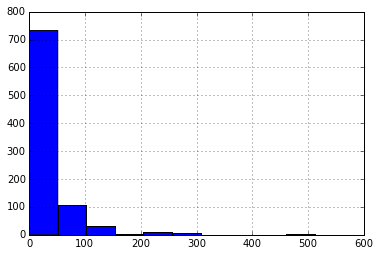

In [16]:
df.Fare.hist()

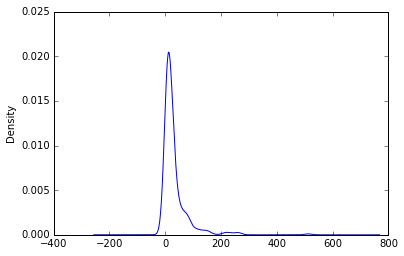

In [18]:
df.Fare.plot(kind='kde')

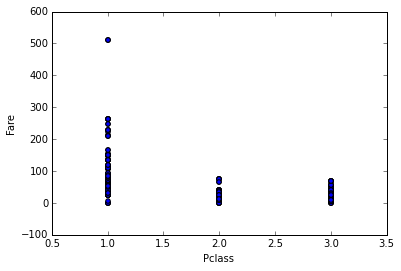

In [19]:
df.plot(x='Pclass', y='Fare', kind='scatter')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb194166190>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fb193e3a890>], dtype=object)

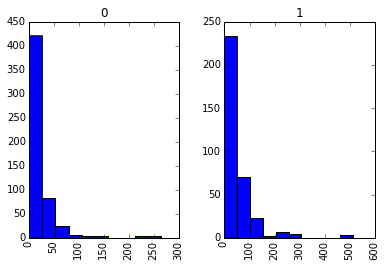

In [21]:
df[['Fare', 'Survived']].hist('Fare', by='Survived')